In [1]:
%run data.py

### Read data from NYC Open Data.

In [2]:
results_df = fetch_nycOpenData(nyc_C_O_issue, 100, 200000)
results_df.head(10)

,job_number,job_type,c_o_issue_date,bin_number,borough,house_number,street_name,block,lot,postcode,...,bin,bbl,nta,location,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,ex_dwelling_unit
0,420662740,NB,2019-11-20T00:00:00.000,4315107,Queens,2002,DEMEREST ROAD,15500,00106,11693,...,4315107,4155000106,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,"{'latitude': '40.598584', 'longitude': '-73.82...",20531,51,3,41,58,NaN
1,102002547,A1,2019-11-20T00:00:00.000,1009706,Manhattan,65,WEST 13 STREET,00577,00001,10011,...,1009706,1005777502,West Village,"{'latitude': '40.736145', 'longitude': '-73.99...",12074,57,4,10,3,NaN
2,104054372,A1,2019-11-20T00:00:00.000,1009286,Manhattan,82,UNIVERSITY PLACE,00569,00027,10003,...,1009286,1005697505,West Village,"{'latitude': '40.733488', 'longitude': '-73.99...",11724,57,4,50,3,0
3,420662072,NB,2019-03-26T00:00:00.000,4464785,Queens,657,HIGHLAND PLACE,16350,00300,11697,...,4464785,4163500300,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,"{'latitude': '40.56255', 'longitude': '-73.9115'}",20533,51,3,41,58,NaN
4,102213800,A1,2019-03-26T00:00:00.000,1051439,Manhattan,9,EAST 96 STREET,01602,00009,10128,...,1051439,1016020009,East Harlem South,"{'latitude': '40.787735', 'longitude': '-73.95...",12426,7,4,51,14,47
5,104051623,NB,2019-03-26T00:00:00.000,1087724,Manhattan,125,WEST 22 STREET,00798,00057,10011,...,1087724,1007987505,Hudson Yards-Chelsea-Flatiron-Union Square,"{'latitude': '40.742628', 'longitude': '-73.99...",12074,12,4,10,7,NaN
6,104895428,A1,2019-03-26T00:00:00.000,1069590,Manhattan,143,WEST 54 STREET,01007,00005,10019,...,1069590,1010070005,Midtown-Midtown South,"{'latitude': '40.763124', 'longitude': '-73.98...",12081,11,4,51,10,1048
7,320916041,NB,2019-03-26T00:00:00.000,3422112,Brooklyn,33,BOND STREET,00166,07502,11201,...,NaN,NaN,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,"{'latitude': '40.688643', 'longitude': '-73.98...",17619,68,2,38,54,NaN
8,200865224,NB,2019-03-26T00:00:00.000,2128502,Bronx,969,EAST 165 STREET,02717,00067,10459,...,2005685,2027170067,Hunts Point,"{'latitude': '40.823959', 'longitude': '-73.89...",10937,8,5,43,24,NaN
9,121192912,NB,2019-03-26T00:00:00.000,1090608,Manhattan,200,EAST 59TH STREET,01332,00045,10022,...,1038639,1013320045,Turtle Bay-East Midtown,"{'latitude': '40.7614', 'longitude': '-73.9662...",12419,71,4,51,9,NaN


In [3]:
df = pandas_to_spark(results_df)

In [4]:
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import month, year


# group table by month.
#filter date and time from 06/2019
df = df.withColumn("date", to_timestamp("c_o_issue_date", "yyyy-MM-dd'T'HH:mm:ss.SSS"))
df = df.filter(df["date"] >= to_timestamp(f.lit('2019-09-01 00:00:00')).cast('timestamp'))
df = df.groupBy(month("date").alias("month")).count()
df = df.filter(df["month"] != 5)

df = df.withColumn("month_name", 
                                            f.when(f.col('month') == 1, "2020-01")\
                                            .when(f.col('month') == 2, "2020-02")\
                                            .when(f.col('month') == 3, "2020-03")\
                                            .when(f.col('month') == 4, "2020-04")\
                                            .when(f.col('month') == 9, "2019-09")\
                                            .when(f.col('month') == 10, "2019-10")\
                                            .when(f.col('month') == 11, "2019-11")\
                                            .when(f.col('month') == 12, "2019-12"))

df = df.orderBy("month_name")
df = df.select(df["month_name"], df["count"].alias("c_o_issue"))
df.show()

+----------+---------+
|month_name|c_o_issue|
+----------+---------+
|   2019-09|     1441|
|   2019-10|     1385|
|   2019-11|     1272|
|   2019-12|     1639|
|   2020-01|     1495|
|   2020-02|     1322|
|   2020-03|     1222|
|   2020-04|      949|
+----------+---------+



In [5]:
avg_data = df.filter(df["month_name"] != "2020-03")
avg_data = avg_data.filter(df["month_name"] != "2020-04")
avg_data.show()

+----------+---------+
|month_name|c_o_issue|
+----------+---------+
|   2019-09|     1441|
|   2019-10|     1385|
|   2019-11|     1272|
|   2019-12|     1639|
|   2020-01|     1495|
|   2020-02|     1322|
+----------+---------+



### Calculate the falling rate.

In [6]:
avg_data.createOrReplaceTempView("avg_data")
avg_num = spark.sql("SELECT avg(c_o_issue) as avg_num FROM avg_data")
avg_num = avg_num.rdd.map(list)
avg_number = avg_num.take(1)[0][0]
print("Average Certificate of Occupancy issued for new buildings before March 2020 is: ", avg_number)

Average Certificate of Occupancy issued for new buildings before March 2020 is:  1425.6666666666667


In [7]:
df.createOrReplaceTempView("latest_data")
latest_number = spark.sql("SELECT c_o_issue FROM latest_data WHERE month_name = \
                                     (SELECT max(month_name) FROM  latest_data)")

latest_number = latest_number.rdd.map(list)
latest_number = latest_number.take(1)[0][0]
falling_rate = (avg_number - latest_number) / avg_number
print("Falling rate is: ", falling_rate)

falling_rate = falling_rate * 100

Falling rate is:  0.33434650455927056


In [8]:
falling_rate_str = "↓" + str('%.2f' % falling_rate) + "%"

In [9]:
import matplotlib.pyplot as plt
plt.close('all')

data = df.toPandas()
data.head(10)

,month_name,c_o_issue
0,2019-09,1441
1,2019-10,1385
2,2019-11,1272
3,2019-12,1639
4,2020-01,1495
5,2020-02,1322
6,2020-03,1222
7,2020-04,949


### Plot.

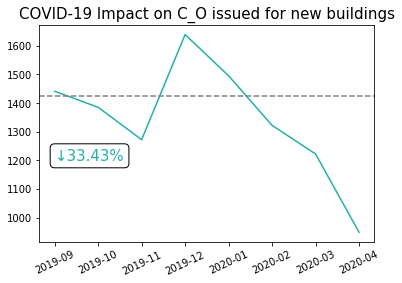

In [10]:
#Certificate of Occupancy issued for new buildings
plt.plot("month_name", "c_o_issue", data = data, color = "lightseagreen")

#average Certificate of Occupancy issued for new buildings before March 2020
plt.axhline(y = avg_number,ls = "dashed",color = "grey") 

#title
plt.title("COVID-19 Impact on C_O issued for new buildings",fontsize = 15)

#annotaion: falling rate
bbox_props = dict(boxstyle="round", facecolor = "white")
plt.text(0, 1200, falling_rate_str, size = 15, color = "lightseagreen", bbox=bbox_props)

plt.xticks(rotation=25)
plt.show()